# Modelo

In [109]:
from classes import Network, MulticastGroup
from multicastpacking import MulticastPacking, solver
import reader

#instancen of the problem
file = "../../../MPP_instances/n30/b30_2.brite"

In [110]:
links = reader.get_network (file)
net = Network (links, nodes = 30)


mgroups = [MulticastGroup (g) for g in reader.get_groups (file) ]

problem = MulticastPacking (net, mgroups)

In [111]:
KSIZE = len(problem.groups)+1
NODES = net.nodes+1

## Criando a variável:  $x_{ij}^{kd}$

In [112]:
from gurobipy import *

m = Model ("MPP by Cost")

var_x = {}
var_y = {}

for link in net.links:
    for k in xrange (1, KSIZE):
        for d in problem.groups[k-1].members:
            x=link[0],link[1],k,d,
            y=link[1],link[0],k,d,
            var_x[x] = m.addVar(vtype=GRB.BINARY, obj=1, name=str(x))
            var_x[y] = m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))
            
m.update ()



## Criando variável $y_{ij}^{k}$

In [113]:
for k in xrange (1, KSIZE):
    for link in net.links:
        x=link[0],link[1],k
        y=link[1],link[0],k
        var_y[x] = m.addVar(vtype=GRB.BINARY, obj=1, name=str(x))
        var_y[y] = m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))

m.update ()

## Criando flow1 

In [114]:
for k in xrange (1, KSIZE):
    for d in problem.groups[k-1].members:
        sk = problem.groups[k-1].source
        _name='flow1',k,d
        m.addConstr (
            quicksum ( var_x[x] for x in tuplelist (var_x).select ('*',sk,k,d) )
            -
            quicksum ( var_x[x] for x in tuplelist (var_x).select (sk,'*',k,d) )
            == -1,
            name=str(_name)
        )

m.update ()

## Criando flow2

In [115]:
for k in xrange (1, KSIZE):
    for d in problem.groups[k-1].members:
        for j in xrange(1,NODES):
            sk = problem.groups[k-1].source
            _name='flow2',k,d,j,       
            m.addConstr (
                quicksum(
                   var_x[x] for x in tuplelist (var_x).select ('*',j,k,d) 
                    if x[1] not in [sk, d]
                )
                -
                quicksum(
                    var_x[x] for x in tuplelist (var_x).select (j,'*',k,d) 
                    if x[0] not in [sk, d]
                )
                == 0,
                name=str(_name)
            )            

m.update ()

## Criando flow3

In [116]:
for k in xrange (1, KSIZE):
    for d in problem.groups[k-1].members:
        sk = problem.groups[k-1].source
        _name='flow3',k,d
        m.addConstr (
            quicksum (
                var_x[x] for x in tuplelist (var_x).select ('*',d,k,d)
            )
            -
            quicksum (
                var_x[x] for x in tuplelist (var_x).select (d,'*',k,d)
            )
            == 1,
            name=str(_name)
        )
        
m.update ()

## Forçando $y_{ij}^{k}$ igual a 1 quando a aresta $(i,j)$ for usada

In [117]:
for k in xrange (1, KSIZE):
    for d in problem.groups[k-1].members:
        for link in net.links:
            x=link[0],link[1],k,d,
            y=link[0],link[1],k
            _name='r4',link[0],link[1],k,d
            m.addConstr ( var_x[x] <= var_y[y], 
                name=str(_name)
            )            
            x=link[1],link[0],k,d,
            y=link[1],link[0],k
            _name='r4',link[1],link[0],k,d
            m.addConstr ( var_x[x] <= var_y[y], 
                name=str(_name)
            )
m.update ()

## Restrição que evita nós folhas não terminais.

In [118]:
for k in xrange(1,KSIZE):
    for link in net.links:
        _name='out',link[0],link[1],k
        m.addConstr(
            quicksum(
                  var_x[x] for x in tuplelist (var_x).select (link[0],link[1],k,'*')              
            )
            -
            var_y[link[0],link[1],k]
            >=
            0,
            name=str(_name)
        )
        _name='out',link[1],link[0],k,
        
        m.addConstr(
            quicksum(
                  var_x[x] for x in tuplelist (var_x).select (link[1],link[0],k,'*')              
            )
            -
            var_y[link[1],link[0],k]
            >=
            0,
            name=str(_name)
        )
m.update()

## Conjunto de Restrições que foça uma capacidade residual mínima

In [119]:
Z = 32

constr = []

for link in net.links:    
    _name='min_res',link
    constr.append(
        m.addConstr (
            links[link][1]
            -
            quicksum (
                (var_y[ (x[0],x[1],x[2]) ] + var_y[ (x[1],x[0],x[2]) ] )*problem.groups[x[2]-1].traffic
                    for x in tuplelist (var_y).select (link[1],link[0],'*')
            )
            >= Z,
            name=str(_name)
        )
    )
m.update ()

## Objective Function

In [120]:
expr  = []
for k in xrange (1, KSIZE ):
    expr.append ( quicksum (var_y[ (l[0],l[1],k) ] * net.links[l][0] 
        for l in net.links.keys()) )    
    expr.append ( quicksum (var_y[ (l[1],l[0],k) ] * net.links[l][0] 
        for l in net.links.keys()) )


m.setObjective (quicksum (expr), GRB.MINIMIZE)
m.update ()


## Obtendo Pareto

In [121]:

m.setParam('OutputFlag',0)
m.optimize ()

result = []

result.append ( (32, m.objVal) )

for i in xrange(31,0,-1):
    for c in constr:
        c.setAttr ('rhs',c.getAttr ('rhs') - 1)
    m.update ()
    m.optimize ()    
    result.append ( (i, m.objVal) )



## Resulatdo Final

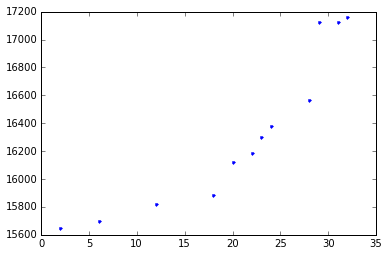

In [122]:
%matplotlib inline

import matplotlib.pyplot as plt

#removing duplicates
seen = set ()
nova = [item for item in result if item[1] not in seen and not seen.add(item[1])]

res = [x[0] for x in nova]
cos = [x[1] for x in nova]

plt.plot (res, cos, '.')
plt.show ()


In [125]:
print (nova)

[(32, 17158.0), (31, 17126.0), (29, 17122.0), (28, 16564.0), (24, 16377.0), (23, 16304.0), (22, 16188.0), (20, 16119.0), (18, 15886.0), (12, 15820.0), (6, 15696.0), (2, 15649.0)]
